<a href="https://colab.research.google.com/github/danielsaggau/Elections-Belarus/blob/main/Belarus_ML_Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
df_pls=pd.read_excel("df_merge_n.xlsx")


In [31]:
df_pls_pls=df_pls.drop(columns=['Unnamed: 0'])
df_pls_pls=df_pls_pls.fillna(0)
df_pls_new=df_pls_pls.drop(columns=['commission_code','number_of_cite'])
df_pls_new.info()

In [ ]:
df_merge1=df_pls_new.drop(columns=['attachment1','attachment2','attachment3','attachment4','attachment5','comment','id','type','name','location','origin','area'])
df_merge1.info()

In [ ]:
df_merge1['lukashenko_share']=df_merge1['Lukashenko']/df_merge1['number_of_voters_who_took_part_in_the_voting']

In [ ]:
df_merge1['lukashenko_share']=df_merge1['lukashenko_share'].replace([np.inf, -np.inf], 0)
df_merge1.info()

In [ ]:
df_merge2=df_merge1.drop(columns=['parent_id','description_x','commission_id','work_title','description_y','city_or_district_within_the_region','area_in_the_city','settlement'])

In [ ]:
df_merge2.columns

In [ ]:
df_merge2['region'].unique()

In [ ]:
!pip install rpy2
%load_ext rpy2.ipython

In [16]:
%%R

install.packages("skimr")
install.packages("glmnet")
install.packages("plotmo")

library(readxl)
library(MASS)
library(tidyverse)
library(broom)
library(skimr)
library(glmnet)
library(plotmo)
set.seed(144)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/skimr_2.1.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1123181 bytes (1.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [20]:
%%R
data <- read_excel("df_merge3.xlsx", sheet = "Sheet1")

p = ncol(data) -1
n <- nrow(data)

ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 
head(data)

R[write to console]: New names:
* `` -> ...1



# A tibble: 6 x 36
   ...1 total_number_of_vo… number_of_voters… number_of_voter… number_of_voters…
  <dbl>               <dbl>             <dbl>            <dbl>             <dbl>
1     0                1656              1329             1319               252
2     1                2646                 0             2249               707
3     2                1805              1717             1714               537
4     3                2270              2122             2122               863
5     4                2746              2383             2383               507
6     5                2319              1829             1829               249
# … with 31 more variables:
#   number_of_voters_who_took_part_in_voting_at_the_place_of_residence <dbl>,
#   number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station <dbl>,
#   Dmitriev <dbl>, Kanopatskaya <dbl>, Lukashenko <dbl>, Tikhanovskaya <dbl>,
#   Cherechen <dbl>,
#   number_of_votes_for_candidat

In [25]:
%%R
summary(set_test)

      ...1       
 Min.   :   1.0  
 1st Qu.: 400.2  
 Median : 772.0  
 Mean   : 766.4  
 3rd Qu.:1118.8  
 Max.   :1581.0  
 total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election
 Min.   :   0                                                                                                            
 1st Qu.:1357                                                                                                            
 Median :1809                                                                                                            
 Mean   :1714                                                                                                            
 3rd Qu.:2192                                                                                                            
 Max.   :4255                                                                                                            
 number_of_voters_wh

In [26]:
%%R
# Naive model with all variables 
model_naive = lm(lukashenko_share~., data = set_train)
summary(model_naive)


Call:
lm(formula = lukashenko_share ~ ., data = set_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66769 -0.03005  0.00760  0.04164  0.40026 

Coefficients: (1 not defined because of singularities)
                                                                                                                           Estimate
(Intercept)                                                                                                              -1.740e-02
...1                                                                                                                      7.349e-05
total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election  3.087e-06
number_of_voters_who_received_ballots                                                                                    -2.072e-05
number_of_voters_who_took_part_in_the_voting                                                                            

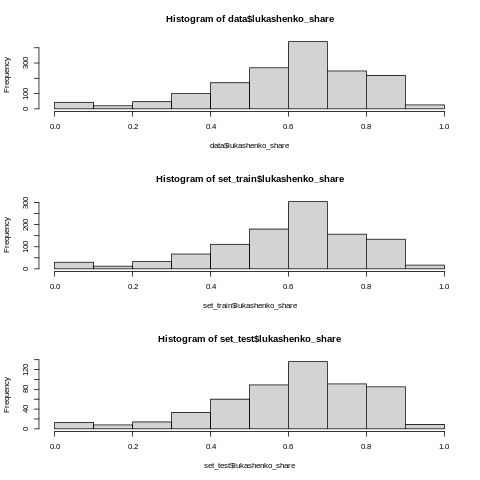

In [28]:
%%R
par(mfrow = c(3, 1))
hist(data$lukashenko_share) 
hist(set_train$lukashenko_share)
hist(set_test$lukashenko_share)

In [29]:
%%R
skim(data)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1583  
Number of columns          36    
_______________________          
Column type frequency:           
  numeric                  36    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable                                                                
 1 ...1                                                                         
 2 total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citi…
 3 number_of_voters_who_received_ballots                                        
 4 number_of_voters_who_took_part_in_the_voting                                 
 5 number_of_voters_who_took_part_in_the_early_voting                           
 6 number_of_voters_who_took_part_in_voting_at_the_place_of_residence           
 7 n